In [1]:
# Install machine learning and explainability libraries
!pip install scikit-learn shap

# Import libraries for data handling, modeling, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# Load your aircraft and maintenance datasets
aircraft = pd.read_csv('/content/aircraft_data.csv')
maintenance = pd.read_csv('/content/maintenance_data.csv')

print("Aircraft dataset shape:", aircraft.shape)
print("Maintenance dataset shape:", maintenance.shape)


Aircraft dataset shape: (500, 6)
Maintenance dataset shape: (60000, 7)


In [3]:
# Count how many maintenance events each aircraft has had
maint_freq = maintenance.groupby('Aircraft_ID').size().reset_index(name='Maint_Count')

# Merge maintenance count into the aircraft master dataset
data = pd.merge(aircraft, maint_freq, on='Aircraft_ID', how='left').fillna(0)

# Define the target: High risk if >10 maintenance events
data['High_Risk_Maint'] = np.where(data['Maint_Count'] > 10, 1, 0)

# Encode categorical columns
le_type = LabelEncoder()
data['Type_Encoded'] = le_type.fit_transform(data['Type'])

le_branch = LabelEncoder()
data['Branch_Encoded'] = le_branch.fit_transform(data['Service_Branch'])

# Select features and target
features = ['Total_Flight_Hours', 'Commission_Year', 'Type_Encoded', 'Branch_Encoded']
X = data[features]
y = data['High_Risk_Maint']

print("Prepared data shape:", X.shape)
print("Target variable breakdown:\n", y.value_counts())


Prepared data shape: (500, 4)
Target variable breakdown:
 High_Risk_Maint
1    500
Name: count, dtype: int64


In [4]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


Confusion Matrix:
 [[100]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [5]:
# Initialize SHAP explainer for the trained model
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)



Generating SHAP summary plot...


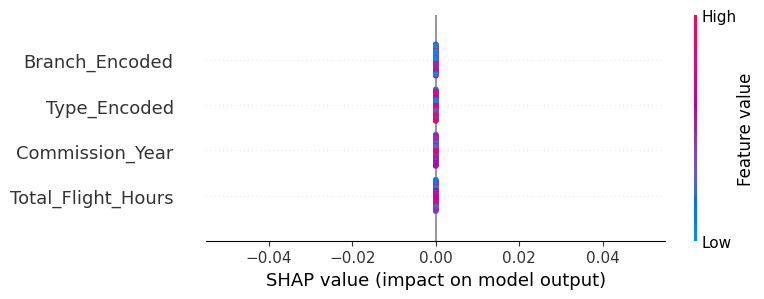


Generating SHAP bar plot...


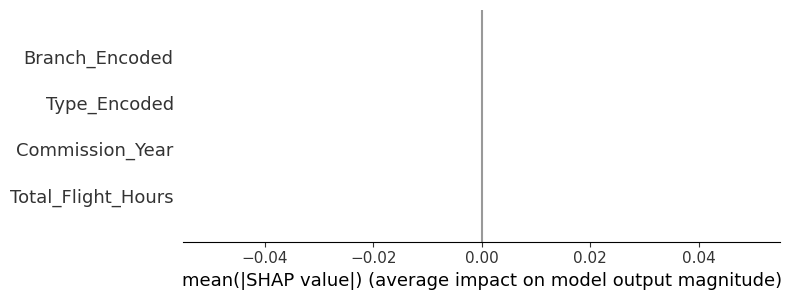

In [7]:
# Check if binary or multi-class
if isinstance(shap_values, list):
    # Binary or multi-class: take index 1 (positive class)
    shap_summary = shap_values[1]
else:
    # Regression or single output
    shap_summary = shap_values

# Generate SHAP summary plot (global feature importance)
print("\nGenerating SHAP summary plot...")
shap.summary_plot(shap_summary, X_test)

# Bar chart of average feature importance
print("\nGenerating SHAP bar plot...")
shap.summary_plot(shap_summary, X_test, plot_type="bar")



Type of shap_values: <class 'numpy.ndarray'>
Detected regression or single-output model
Shape of shap_to_plot: (100, 4)

Generating SHAP summary (beeswarm) plot...


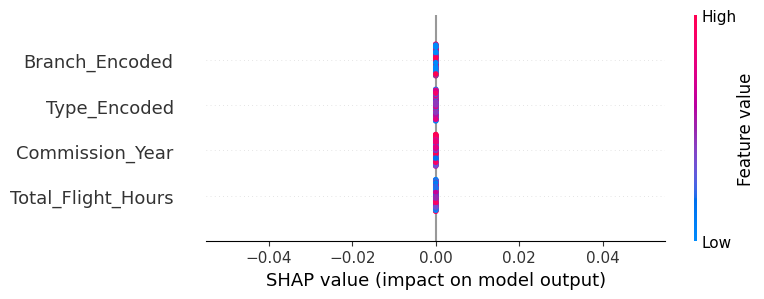


Generating SHAP summary (bar) plot...


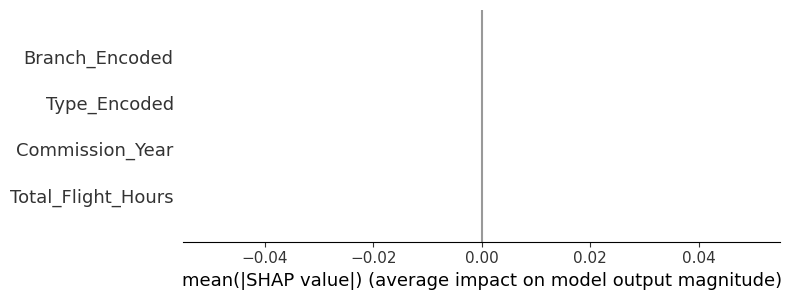


Generating dependence plot for: Total_Flight_Hours


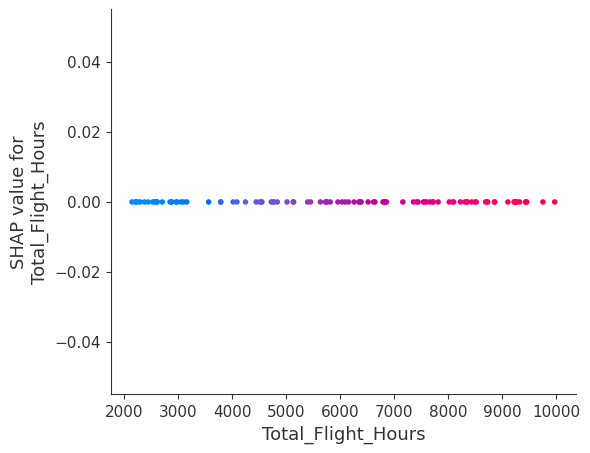


Generating SHAP force plots for first 3 samples...


/usr/local/lib/python3.11/dist-packages/shap/plots/_force_matplotlib.py:325: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min_x, max_x)


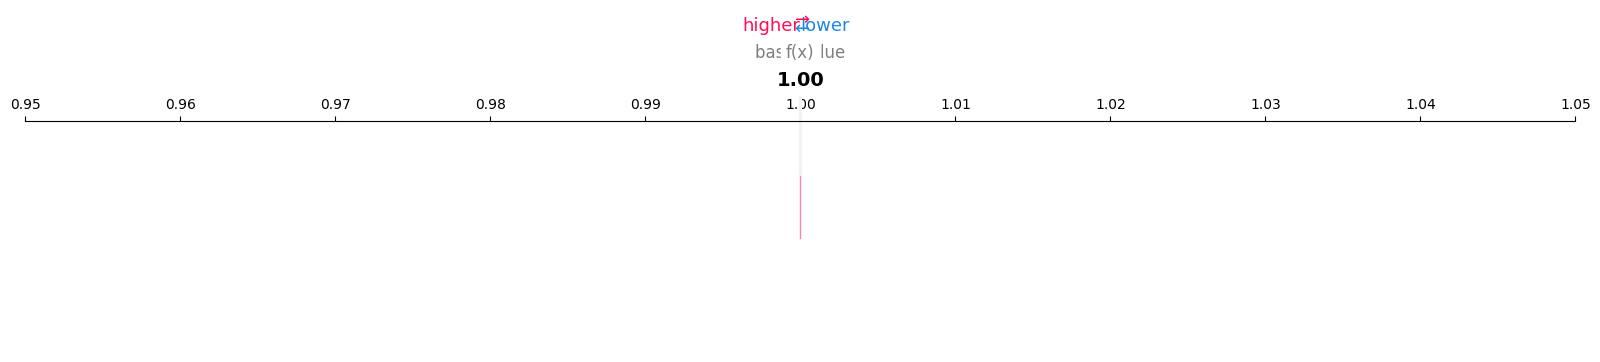

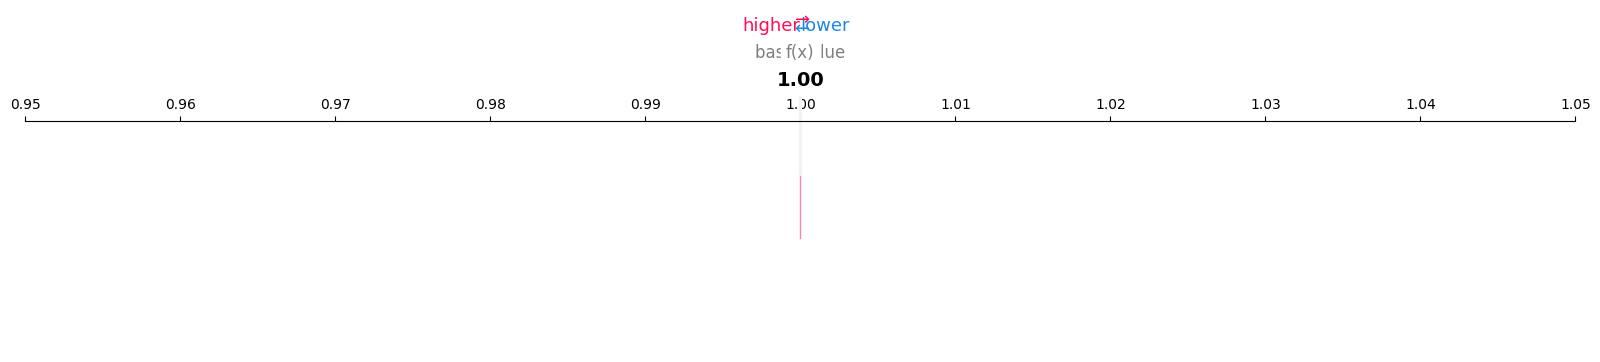

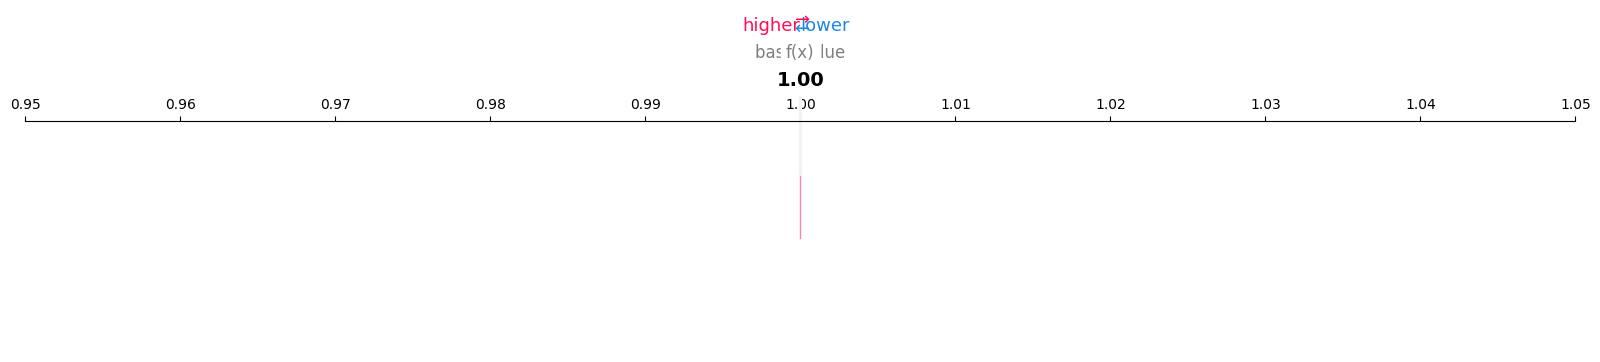

In [12]:
import shap

# Recalculate SHAP values (to be sure)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Check what type of output we got:
print("Type of shap_values:", type(shap_values))

# --- CASE 1: Binary or multi-class (shap_values is a list) ---
if isinstance(shap_values, list):
    print("Detected binary or multi-class model")
    # For binary, take shap_values[1] (positive class)
    shap_to_plot = shap_values[1]
else:
    # --- CASE 2: Regression or single-output (shap_values is a matrix) ---
    print("Detected regression or single-output model")
    shap_to_plot = shap_values

# Confirm shape
print("Shape of shap_to_plot:", shap_to_plot.shape)

# --- Summary Plot (Beeswarm) ---
print("\nGenerating SHAP summary (beeswarm) plot...")
shap.summary_plot(shap_to_plot, X_test)

# --- Summary Plot (Bar Chart) ---
print("\nGenerating SHAP summary (bar) plot...")
shap.summary_plot(shap_to_plot, X_test, plot_type="bar")

# --- Dependence Plot (Top Feature) ---
important_feature_idx = np.argmax(np.abs(shap_to_plot).mean(axis=0))
important_feature_name = X_test.columns[important_feature_idx]
print(f"\nGenerating dependence plot for: {important_feature_name}")
shap.dependence_plot(important_feature_name, shap_to_plot, X_test)

# --- Local Force Plots for First 3 Samples ---
print("\nGenerating SHAP force plots for first 3 samples...")
shap.initjs()
for i in range(3):
    shap.force_plot(
        explainer.expected_value[1] if isinstance(shap_values, list) else explainer.expected_value,
        shap_to_plot[i],
        X_test.iloc[i],
        matplotlib=True
    )



In [13]:
# Predict maintenance risk on the entire aircraft dataset
data['Predicted_Risk'] = rf.predict(data[features])

# Get only aircraft predicted as high-risk
high_risk_aircraft = data[data['Predicted_Risk'] == 1]

# Sort by number of past maintenance events (descending)
top_high_risk = high_risk_aircraft.sort_values(by='Maint_Count', ascending=False).head(10)

# Display top 10 high-risk aircraft
print("\n=== Top Predicted High-Risk Aircraft ===")
print(top_high_risk[['Aircraft_ID', 'Tail_Number', 'Type', 'Total_Flight_Hours', 'Maint_Count']])

# Save results to CSV (optional)
top_high_risk.to_csv('top_high_risk_aircraft.csv', index=False)
print("\nSaved top high-risk aircraft to 'top_high_risk_aircraft.csv'")



=== Top Predicted High-Risk Aircraft ===
     Aircraft_ID Tail_Number   Type  Total_Flight_Hours  Maint_Count
305          306     LM-1305   RQ-4                3200          157
20            21     LM-1020   F-35                3057          148
435          436     LM-1435   F-16                6038          148
178          179     LM-1178  C-130                8389          147
399          400     LM-1399  C-130                2891          145
311          312     LM-1311   F-16                3207          145
317          318     LM-1317   F-35                9869          145
251          252     LM-1251   F-35                8348          145
188          189     LM-1188   F-35                7163          145
325          326     LM-1325    E-3                5319          145

Saved top high-risk aircraft to 'top_high_risk_aircraft.csv'
